# **Assignment 1**, **dataset 2**


# Problem statement

Statlog (German Credit Data)

https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data <-- Refer to the documentation for the details that are not mentioned here

This dataset classifies people described by a set of attributes as good or bad credit risks. The dataset uses codes to describe the categorigal attributes. Make sure to deal with those appropriatelly. See the documentation link above.

Cost Matrix

This dataset requires use of a cost matrix (see below)




|   | 1 | 2 |
|---|---|---|
| 1 | 0 | 1 |
| 2 | 5 | 0 |

(1 = Good,  2 = Bad)

the rows represent the actual classification and the columns
the predicted classification.

It is worse to class a customer as good when they are bad (cost 5),
than it is to class a customer as bad when they are good (cost 1).

Make sure to include this information when reporting your results


### Loading the dataset

In [426]:
!pip install ucimlrepo

In [427]:
# Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

In [428]:
# You are free to use this code snippet in your Python environment or download the dataset manually and load into the notebook.
from ucimlrepo import fetch_ucirepo

# fetch dataset
credit_data = fetch_ucirepo(id=144)

# data (as pandas dataframes)
X = credit_data.data.features
y = credit_data.data.targets

# metadata
print(credit_data.metadata)

# variable information
print(credit_data.variables)

# Make sure to split the data for validation

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

## **Exploratory Data Analysis**

The student will have to make a written analysis of the data being loaded (depending on the dataset that was assigned to them). They should apply methods of inspecting the data and make some exploratory data analysis

In [429]:
X.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


In [430]:
y.head()

,class
0,1
1,2
2,1
3,1
4,2


As we can see above, the dataset consists of 20 attributes based on which people can be classified as good or bad credit risks. The dependent variable therefore is whether the person is a good (value of 1) or bad (value of 2) credit risk and the attributes are the independent variables. The problem at hand is framed as a binary classification. Since the attributes are just numbered, in the first step, I replaced the current column names with their (shortened) descritption to facilitate the exploratory data analysis.

In [431]:
name_map = dict(zip(credit_data.variables['name'], credit_data.variables['description']))
X = X.rename(columns=name_map)
X.columns

Index(['Status of existing checking account', 'Duration', 'Credit history',
       'Purpose', 'Credit amount', 'Savings account/bonds',
       'Present employment since',
       'Installment rate in percentage of disposable income',
       'Personal status and sex', 'Other debtors / guarantors',
       'Present residence since', 'Property', 'Age', 'Other installment plans',
       'Housing', 'Number of existing credits at this bank', 'Job',
       'Number of people being liable to provide maintenance for', 'Telephone',
       'foreign worker'],
      dtype='object')

In [432]:
print(X.columns)
shortened_names = {
    'Installment rate in percentage of disposable income': 'Installment rate',
    'Number of existing credits at this bank': 'No credits',
    'Number of people being liable to provide maintenance for': 'No Dependents'
}
X = X.rename(columns=shortened_names)

Index(['Status of existing checking account', 'Duration', 'Credit history',
       'Purpose', 'Credit amount', 'Savings account/bonds',
       'Present employment since',
       'Installment rate in percentage of disposable income',
       'Personal status and sex', 'Other debtors / guarantors',
       'Present residence since', 'Property', 'Age', 'Other installment plans',
       'Housing', 'Number of existing credits at this bank', 'Job',
       'Number of people being liable to provide maintenance for', 'Telephone',
       'foreign worker'],
      dtype='object')


In [433]:
print(X.shape) # 1000 rows, 20 attributes
X.head()

(1000, 20)


,Status of existing checking account,Duration,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate,Personal status and sex,Other debtors / guarantors,Present residence since,Property,Age,Other installment plans,Housing,No credits,Job,No Dependents,Telephone,foreign worker
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


In [434]:
y.iloc[0] # label of first data point


,0
class,1


In [435]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Status of existing checking account  1000 non-null   object
 1   Duration                             1000 non-null   int64 
 2   Credit history                       1000 non-null   object
 3   Purpose                              1000 non-null   object
 4   Credit amount                        1000 non-null   int64 
 5   Savings account/bonds                1000 non-null   object
 6   Present employment since             1000 non-null   object
 7   Installment rate                     1000 non-null   int64 
 8   Personal status and sex              1000 non-null   object
 9   Other debtors / guarantors           1000 non-null   object
 10  Present residence since              1000 non-null   int64 
 11  Property                             1000 no

Above, we have a look at the first five rows (=individuals to classify as good or bad credit risks). The first individual is classified as good credit risk based on the following attributes:

- Status of existing checking account: A11 (< 0 DM)

- Duration: 6 months

- Credit history: A34 (critical account/  other credits existing (not at this bank))

- Purpose: A43 (radio/television), person takes the credit to buy a radio or television

- Credit amount: 1169

- Savings account/bonds: A65 (unknown/ no savings account)

- Present employment since: A75 (>= 7 years)

- Installment rate: 4 % of percentage of disposable income

- Personal status and sex: A93 (male, single)

- Other debtors / guarantors: A101 (none)

- Present residence since: 4

- Property: A121 (real estate)

- Age: 67

- Other installment plans: A143 (none)

- Housing: A152 (own)

- No credits: 2

- Job: A173 (skilled employee / official)

- No Dependents: 1 person being liable to provide maintenance for

- Telephone: A192 (none)

- foreign worker: A201 (yes)



We can see that we have no nan values, and 7 numerical or continuous attributes and 13 categorical variables that are expressed as codes, e.g. the attribute "Telephone" describes whether there is a telephone number registered under the customers name (value of A192) or not (A191). For the numerical values, we can conduct some basic statistics. Below, we can for example see that the average age is 35 years and the average credit amount is 3271.26 DM. We also see that age has a smaller scale than for example credit amount and depending on the algorithm we use, it might therefore be crucial to normalize the data if the algorithm/ML method is sensitive to the scale of the data (Géron 2022: 69).

In [436]:
X.describe() # inspect the numerical values. For scale sensitive algorithms normalization might be applicable.

,Duration,Credit amount,Installment rate,Present residence since,Age,No credits,No Dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [437]:
df = X.copy()
df['credit risk'] = y["class"]
print(df.isnull().sum()) # check for missing values
print(df.duplicated().sum()) # check for duplicates

Status of existing checking account    0
Duration                               0
Credit history                         0
Purpose                                0
Credit amount                          0
Savings account/bonds                  0
Present employment since               0
Installment rate                       0
Personal status and sex                0
Other debtors / guarantors             0
Present residence since                0
Property                               0
Age                                    0
Other installment plans                0
Housing                                0
No credits                             0
Job                                    0
No Dependents                          0
Telephone                              0
foreign worker                         0
credit risk                            0
dtype: int64
0


For the numerical values, we can plot pairwise relationships/patterns between variables and visualize their distributions (in the diagonals). We observe for example that the majority of people taking credits is between 20 and 40, and "Duration" and "Credit amount" seem to be positively correlated. A correlation or pattern for the credit risk target variable is not clearly detectable. We can further observe that the dataset is imbalanced since the majority of datapoints are labeled as good credit risk.

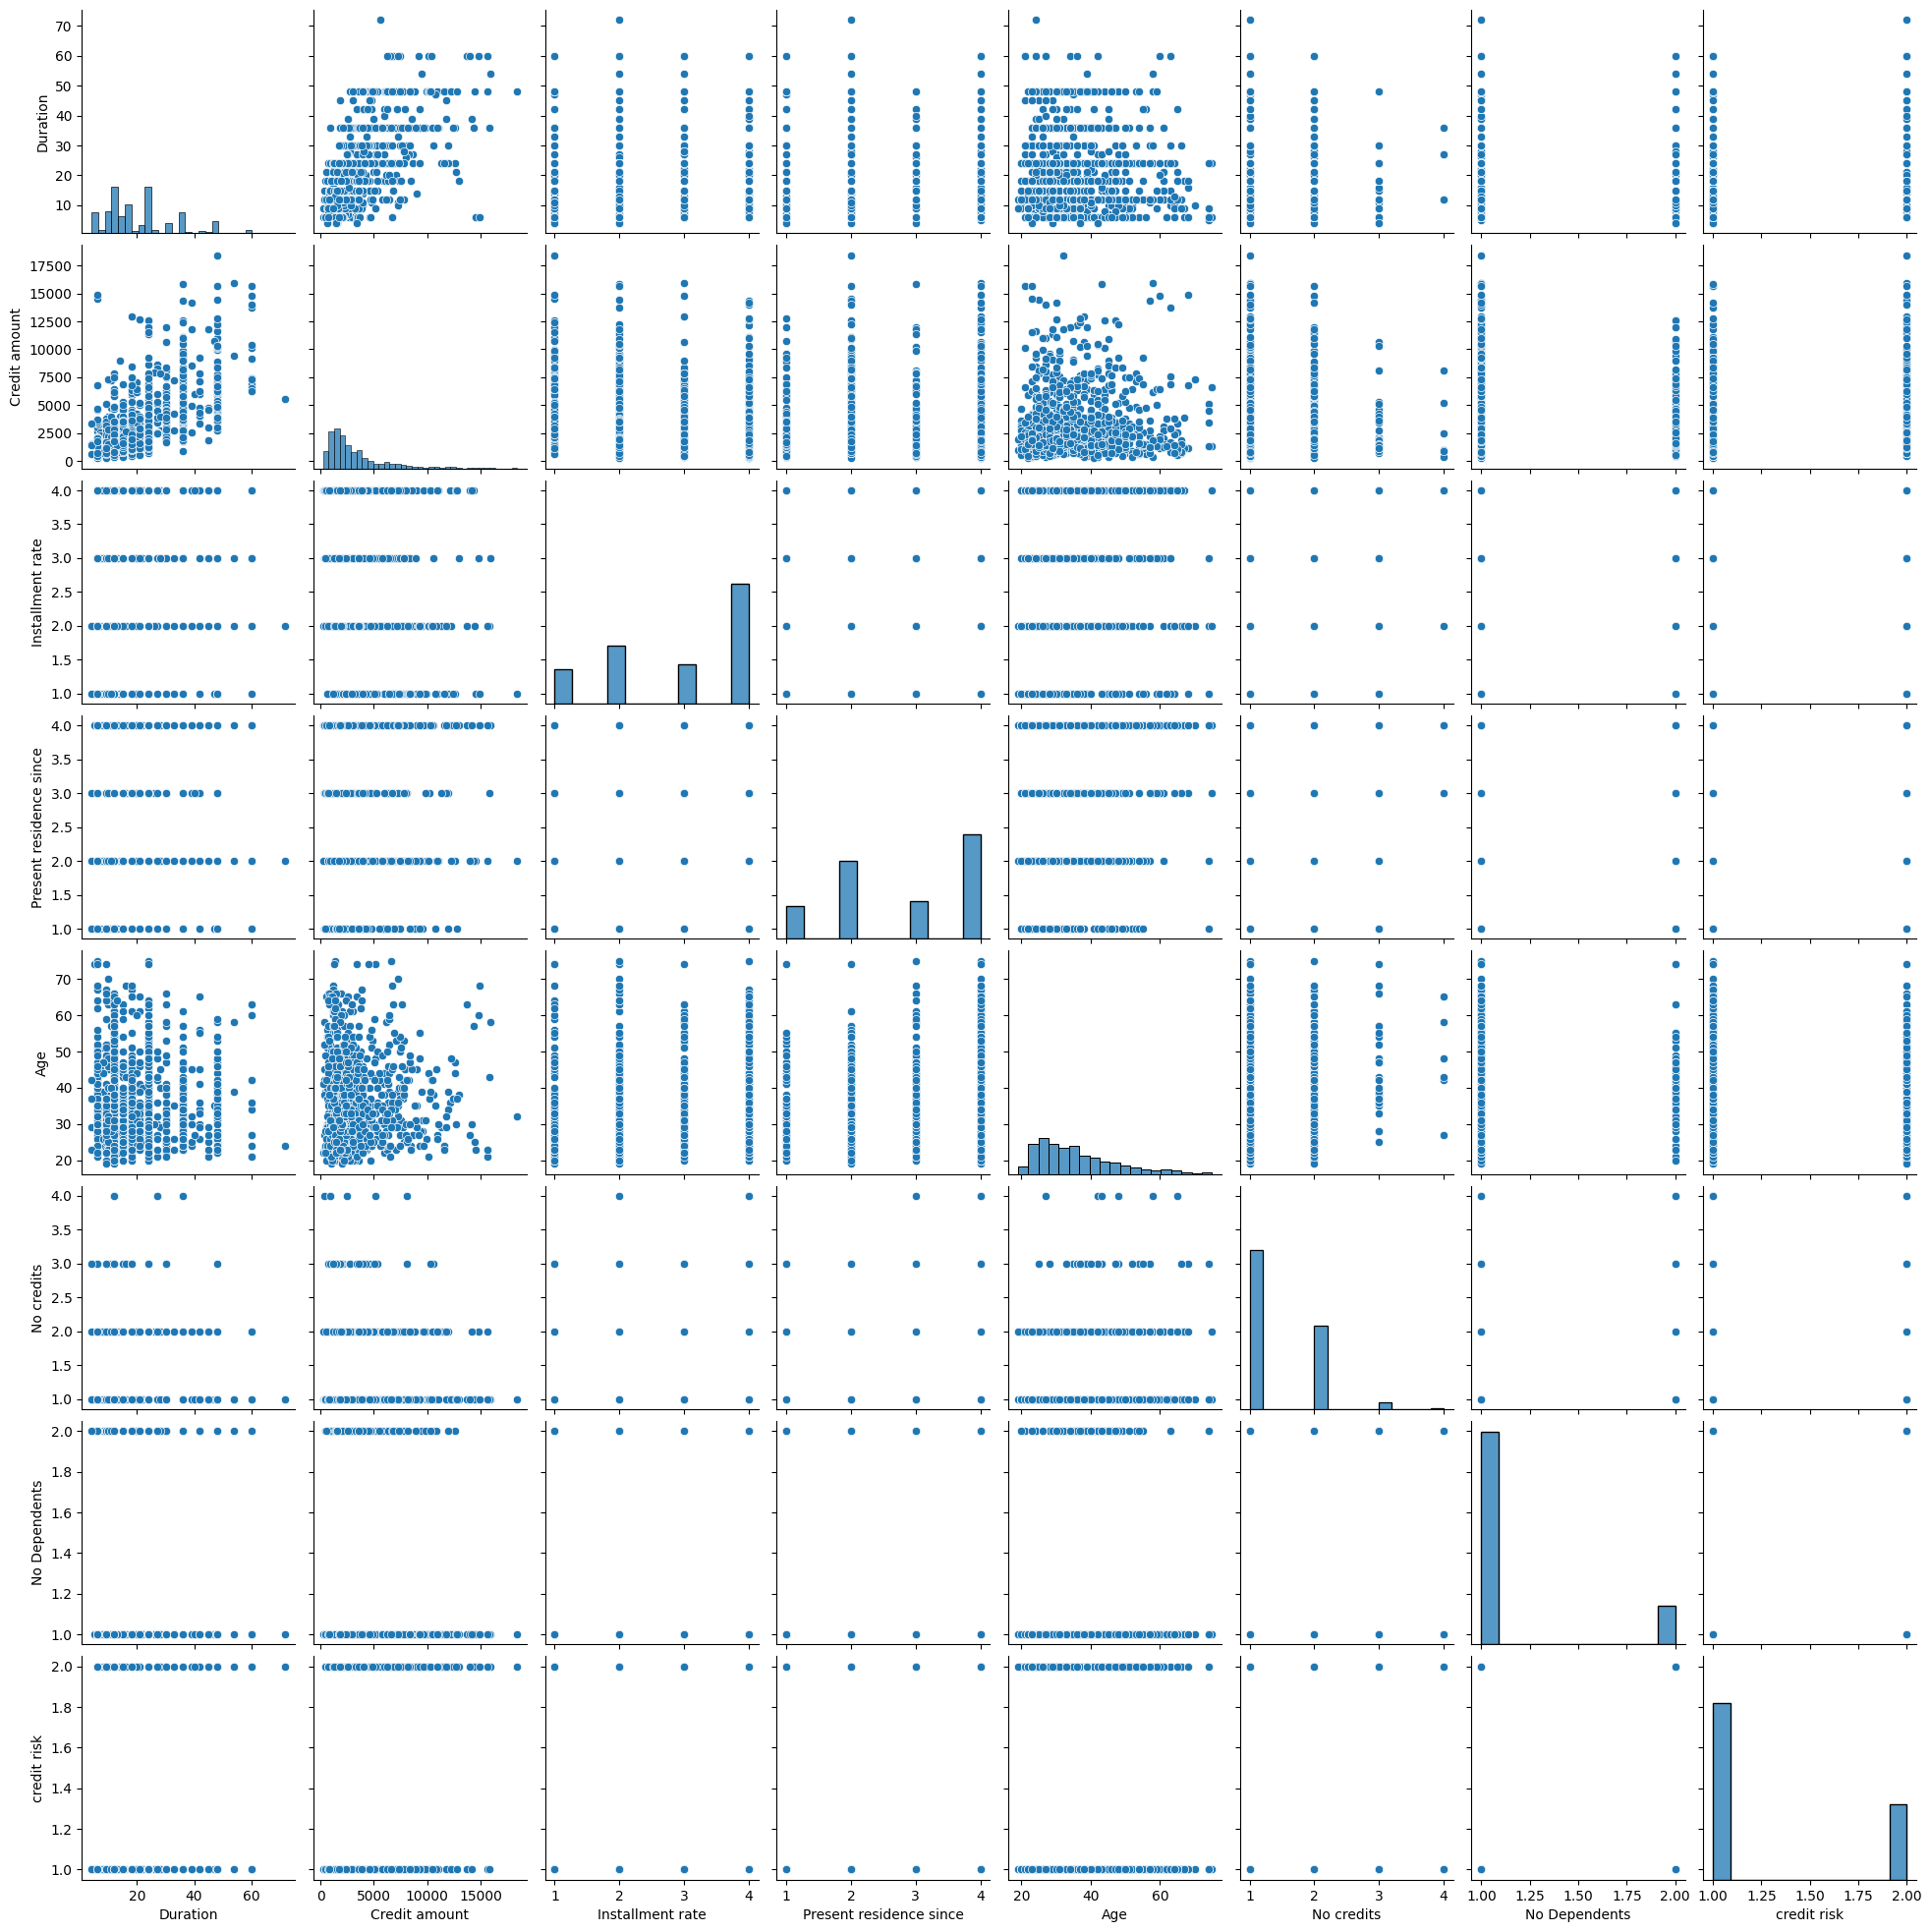

In [438]:
# sns.pairplot(df, hue="credit risk")
sns.pairplot(df)
plt.show()

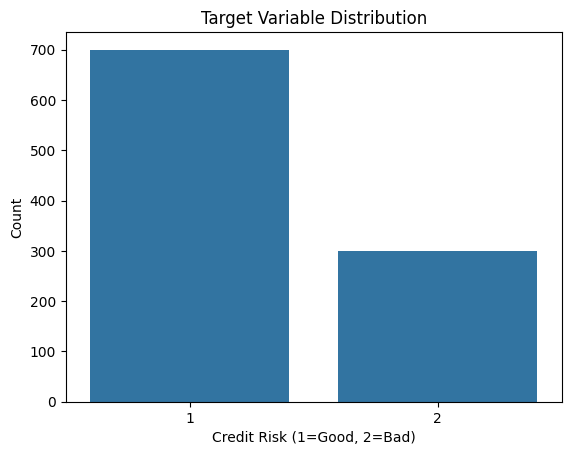

In [439]:
sns.countplot(x=df["credit risk"])
plt.title("Target Variable Distribution")
plt.xlabel("Credit Risk (1=Good, 2=Bad)")
plt.ylabel("Count")
plt.show()
# y.value_counts()

To facilitate binary classification, I converted the labels into 0 (bad credit risk) and 1 (good credit risk).

In [440]:
df["credit risk"] = df["credit risk"].replace(2, 0)

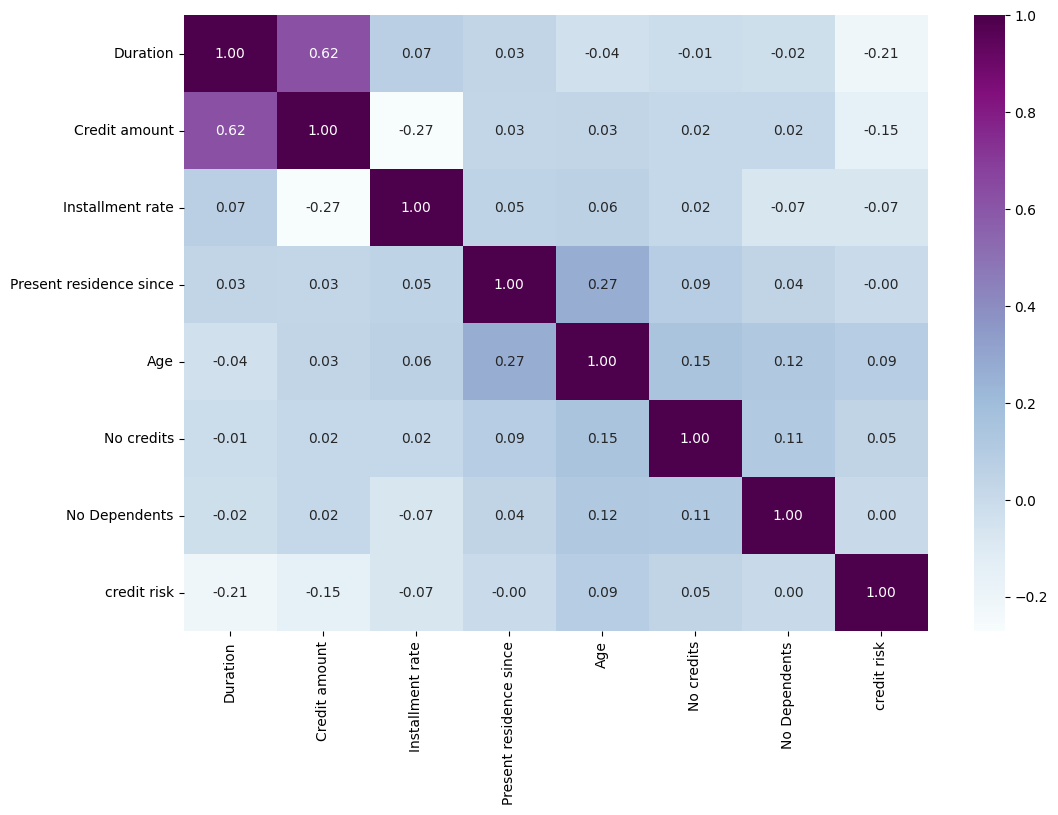

In [441]:
numeric_df = df.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', fmt=".2f")
plt.show()

Above we can see that there is a slight negative correlation between credit risk (target variable) and duration (-0.21), indicating that longer durations are more likely bad credit risks, and between credit amount and credit risk (-0.15), indicating that larger credit amounts increase the classification as bad credit risk. A very slight positive correlation is observable between age and credit risk (0.09). There is no correlation at all between "No Dependents" and "present residence since". Furthermore, between the independent variables, there is a positive correlation between credit amount and duration (0.62, which might indicate slight multicollinearity), and a moderately positive correlation between age and "present residence since". However, dropping values because no correlation can be detected could be problematic, since two variables can also exhibit a non-linear relationship (cf. Géron 2022: 59). This would be for example be problematic for decision trees since they are non-linear models.

  Status of existing checking account  Duration Credit history Purpose  \
0                                 A11         6            A34     A43   
1                                 A12        48            A32     A43   
2                                 A14        12            A34     A46   
3                                 A11        42            A32     A42   
4                                 A11        24            A33     A40   

   Credit amount Savings account/bonds Present employment since  \
0           1169                   A65                      A75   
1           5951                   A61                      A73   
2           2096                   A61                      A74   
3           7882                   A61                      A74   
4           4870                   A61                      A73   

   Installment rate Personal status and sex Other debtors / guarantors  ...  \
0                 4                     A93                       A101  .

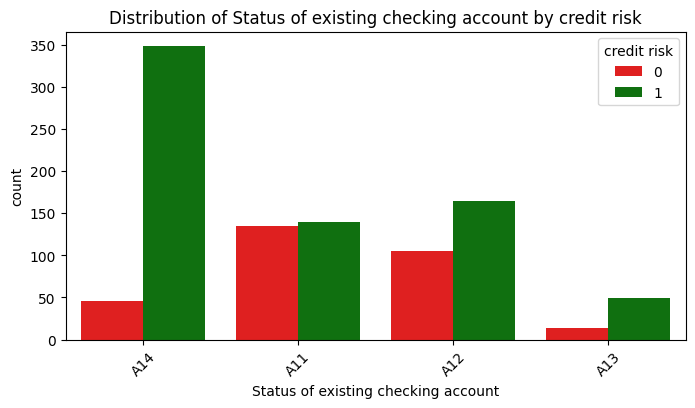

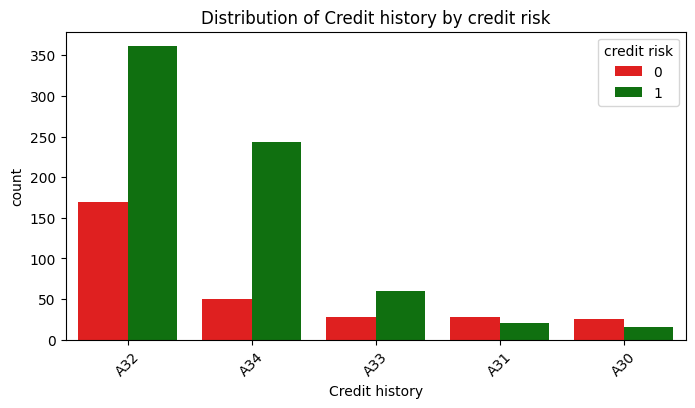

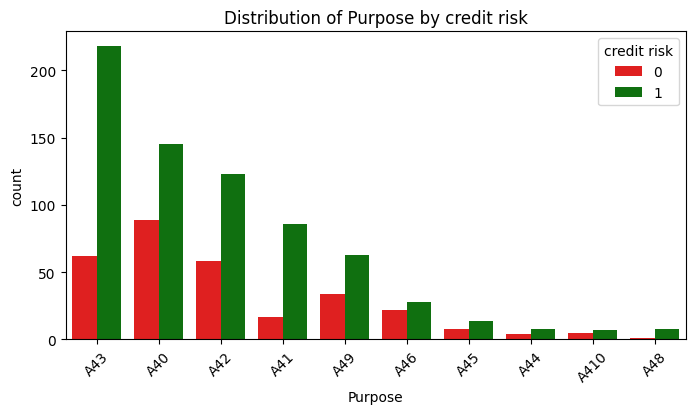

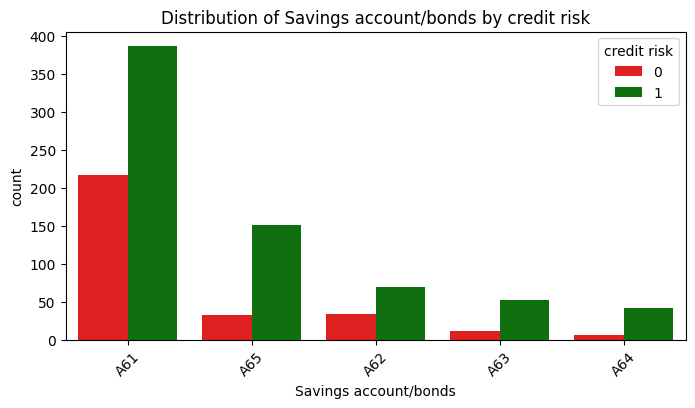

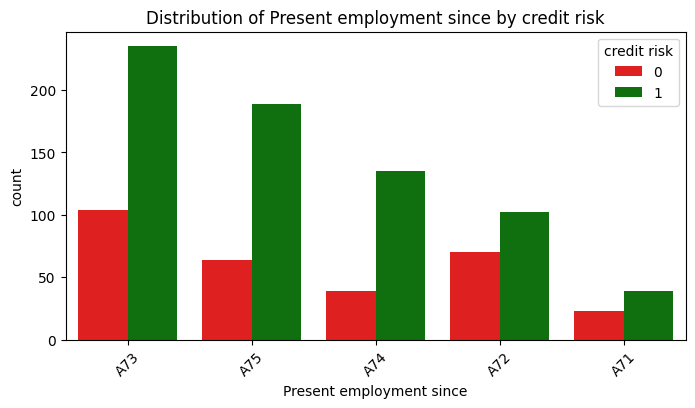

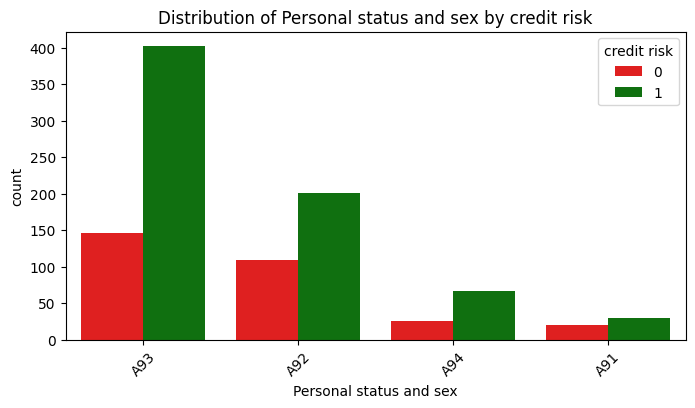

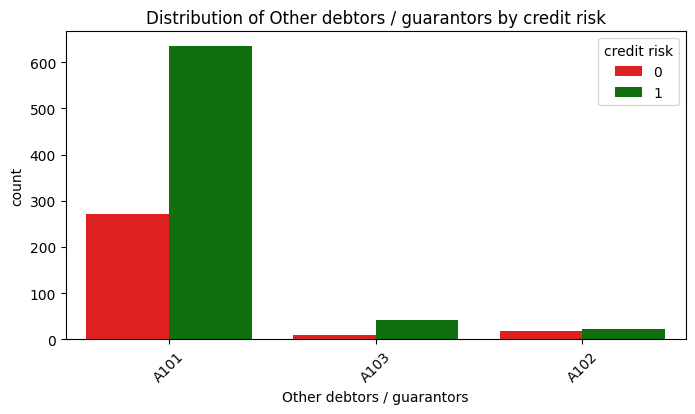

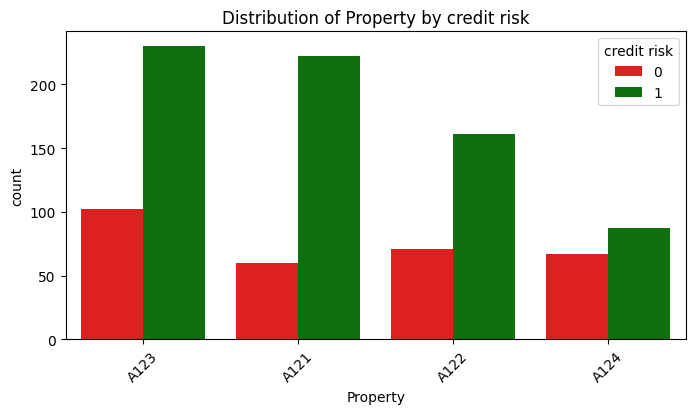

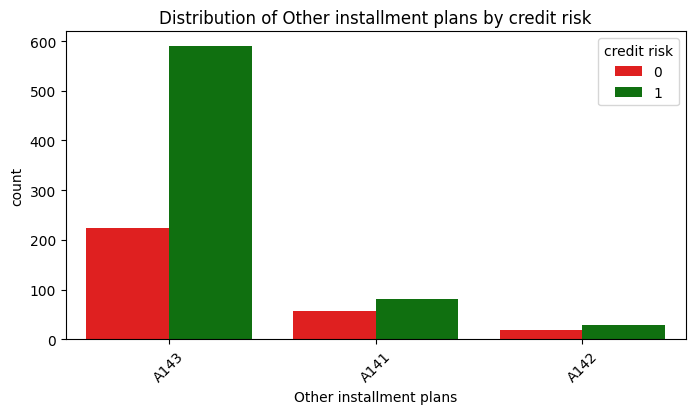

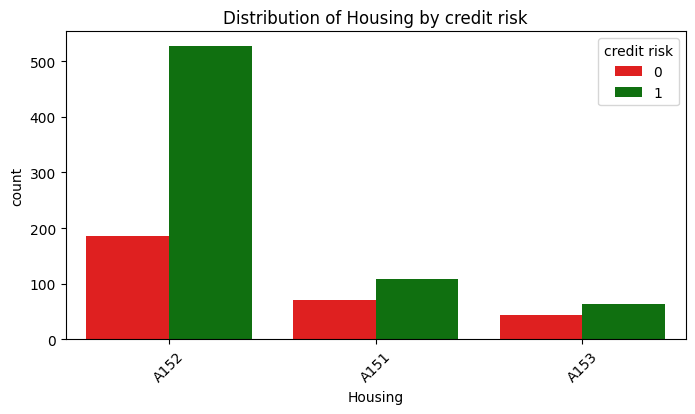

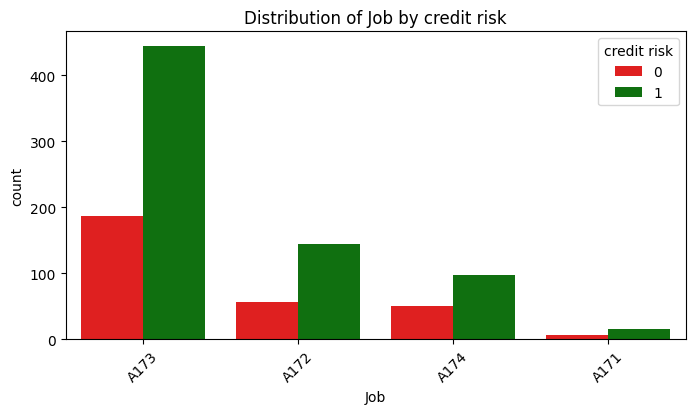

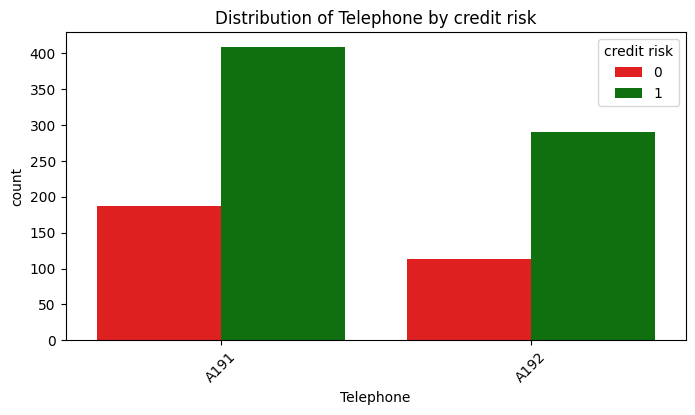

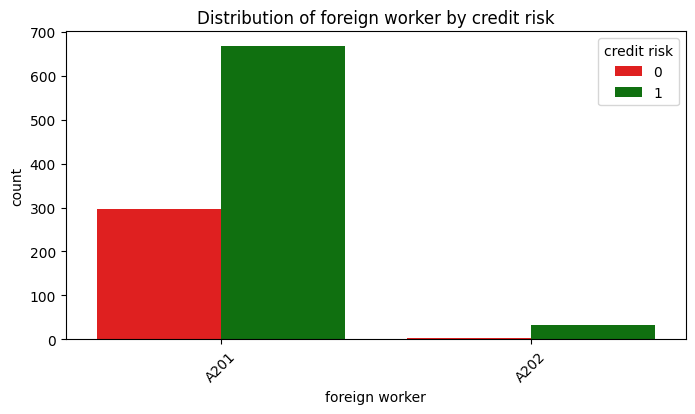

In [442]:
print(df.head())

palette = {1: 'green', 0: 'red'}

for col in df.select_dtypes(include='object').columns: # check categorical values
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='credit risk', data=df, order=df[col].value_counts().index, palette=palette)
    plt.title(f"Distribution of {col} by credit risk")
    plt.xticks(rotation=45)
    plt.show()

To understand the relationship between the categorical values and the target variable (credit risk), I visualized the distribution of each categorical feature, grouped by credit risk. For example, we can observe that people having a checking account status of A14 (no checking account) are in the majority of cases evaluated as good credit risk. When it comes to the distribution of credit history however, the patterns are counterintuitive. While the majority of people with a credit history of A32 (existing credits paid back duly till now) is evaluated as good credit risk, people with critical accounts/ other credits existing (not at this bank) (A34) and people with dely in paying off in the past (A33) are evaluated as good credit risk. More surprisingly, A31 (all credits at this bank paid back duly) and A30 (no credits taken/ all credits paid back duly) are more likely to be evaluazed as bad credit risk. It might be that I lack domain specific knowledge to interprete this, or that other attributes play a larger role in prediciting whether a person is a good or bad credit risk (or many features interact together). However, these plots just offer current trends in the data and we have to take into account that the data is imbalanced.

## **Data Preprocessing**:

If applicable, the student will create new features from existing data to improve model performance and/or select the most relevant features for the model.

Here, I converted labels to 0 and 1 for binary classification. At this point, one could also drop attributes that are less important and would create noise in the model or create new attributes. Furthermore, we have to consider the class imbalance. Since the dataset is rather small (1000 instances), I chose to not undersample towards the minority class. On the other hand, data augmentation with tabular data is not as straightforward as with images or text and I lack domain knowledge. Therefore, I chose to 1) evaluate feature importances of the models and then dropping columns, 2) to only report evaluation metrics like F1-score, AUC, and ROC, and a cost metric, instead of accuracy which can be misleading in imbalanced datasets.

In [443]:
# convert labels for binary classification
print(y["class"].unique())
y["class"] = y["class"].replace(2, 0)
print(y["class"].unique())

[1 2]
[1 0]


## **Data Transformation**

The student should prepare the data for the training. Augmenting, splitting, and otherwise transforming should be done here.

Here, I performed:

- splitting
- scaling
- converting categorical to numerical values

In [444]:
# converting categorical to numerical values and scale numerical values
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns # we want to scale only the numerical values

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols) # apply one hot encoding to categorical columns
    ])

X_transformed = preprocessor.fit_transform(X)
X_transformed.shape

(1000, 61)

In [445]:
print(X_transformed.shape)
print(X.shape)

(1000, 61)
(1000, 20)


Here, we are retrieving the feature names from the one-hot-encoding applied to the categorical features above for further feature importance analysis conducted below. Note that this might not be the best approach since we are splitting categorical attributes into several attributes.

In [446]:
one_hot_encoder = preprocessor.named_transformers_['cat'] # assess the fitted onehot encoder cf. https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

one_hot_encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_cols) # get feature names of the categorical columns, cf. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

num_feature_names = numerical_cols.tolist() # leave numerical columns as they are
all_feature_names = num_feature_names + list(one_hot_encoder_feature_names)
print(all_feature_names)

['Duration', 'Credit amount', 'Installment rate', 'Present residence since', 'Age', 'No credits', 'No Dependents', 'Status of existing checking account_A11', 'Status of existing checking account_A12', 'Status of existing checking account_A13', 'Status of existing checking account_A14', 'Credit history_A30', 'Credit history_A31', 'Credit history_A32', 'Credit history_A33', 'Credit history_A34', 'Purpose_A40', 'Purpose_A41', 'Purpose_A410', 'Purpose_A42', 'Purpose_A43', 'Purpose_A44', 'Purpose_A45', 'Purpose_A46', 'Purpose_A48', 'Purpose_A49', 'Savings account/bonds_A61', 'Savings account/bonds_A62', 'Savings account/bonds_A63', 'Savings account/bonds_A64', 'Savings account/bonds_A65', 'Present employment since_A71', 'Present employment since_A72', 'Present employment since_A73', 'Present employment since_A74', 'Present employment since_A75', 'Personal status and sex_A91', 'Personal status and sex_A92', 'Personal status and sex_A93', 'Personal status and sex_A94', 'Other debtors / guaran

In [447]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y) # use stratified smapling
X_eval, X_val, y_eval, y_val = train_test_split(X_eval, y_eval, test_size=0.5, random_state=0, stratify=y_eval) # we need a validation set for Optuna!

print("X_train shape:", X_train.shape)
print("X_eval shape:", X_eval.shape)
print("y_train shape:", y_train.shape)
print("y_eval shape:", y_eval.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train_processed = preprocessor.transform(X_train)
X_eval_processed = preprocessor.transform(X_eval)
X_val_processed = preprocessor.transform(X_val)

print(X_train_processed.shape)
print(X_eval_processed.shape)
print(X_val_processed.shape)

X_train shape: (800, 20)
X_eval shape: (100, 20)
y_train shape: (800, 1)
y_eval shape: (100, 1)
X_val shape: (100, 20)
y_val shape: (100, 1)
(800, 61)
(100, 61)
(100, 61)


## **Model Selection**


The student should implement a simple model as a baseline to compare more complex models. The student should try more complex modes and justify their rejection or acceptance.

As a simple baseline I chose logistic regression since it is a simple, interpretable model that is efficient to train. Furthermore, the webpage of the dataset (https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data) lists the baseline model performance for different models. The worst performing model here was a neural network, which might be too complex to handle the small amount of tabular data here. Logistic regression performed well (average accuracy of 0.75), followed by Random Forest (average accuracy of 0.78). To further compare and quantify the advantage of ensemble modeling, I further trained a decision tree on the data set.

First, we have to check whether we can accept the basic assumptions of the linear regression model (cf. AI25_ex02_regression_solved/Solved_logistic_regression_heart_attack.ipynb):

- Binary outcome: yes, 'credit risk' is binary
- Independence: cannot be determined by plots alone
- Linearity: appears reasonable for some features.
- No multicollinearity: There are some correlation between 'credit risk' and independent variables. Some independent variables exhibit correlations (e.g., credit amount and duration with a correlation of 0.62) but no major mulitcollinearity can be detected.


My approach to include the cost matrix (FPs are 5 times more costly than FNs) and to address the class imbalance was the following:

1) I trained all models with the argument class_weights="balanced" ("The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data", cf. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html, accessed Aug 7, 2025).

2) I evaluated model performance using a total cost = (fp * 5) + (fn * 1)

3) For the decision tree and the RandomForest I further optimized the hyperparameters to minimize the cost on the validation set.

## **Reporting the results**

The student should report the results. Identify which features are most influential in the model’s predictions, if applicable for the dataset and model used.

In [448]:
model = LogisticRegression(solver="lbfgs", class_weights="balanced", max_iter=1000)
model.fit(X_train_processed, y_train)
print("Train score:", model.score(X_train_processed, y_train))
print("Eval score:", model.score(X_eval_processed, y_eval))

Train score: 0.7775
Eval score: 0.78


              precision    recall  f1-score   support

           0       0.68      0.50      0.58        30
           1       0.81      0.90      0.85        70

    accuracy                           0.78       100
   macro avg       0.74      0.70      0.71       100
weighted avg       0.77      0.78      0.77       100

AUC Score: 0.8285714285714285
Total misclassification cost on test set: 82


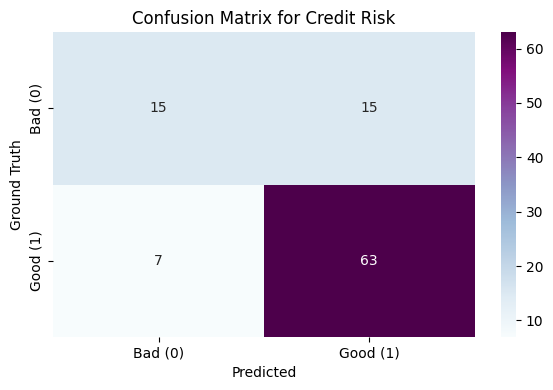

In [449]:
y_pred = model.predict(X_eval_processed)
#print(np.sum(y_pred == 1))
#print(np.sum(y_pred == 0))
#print(np.sum(y_eval == 1))
#print(np.sum(y_eval == 0)) # making sure the labels on the confusion matrix are correctly ordered

def plot_cm(cm):
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=["Bad (0)", "Good (1)", ], yticklabels=["Bad (0)", "Good (1)"])
  plt.xlabel('Predicted')
  plt.ylabel('Ground Truth')
  plt.title('Confusion Matrix for Credit Risk')
  plt.tight_layout()
  plt.show()


def evaluate_model(y_eval, y_pred, y_pred_proba):
  print(classification_report(y_eval, y_pred))
  cm = confusion_matrix(y_eval, y_pred)
  # print("AUC Score:", roc_auc_score(y_eval, y_pred_proba))
  tn, fp, fn, tp = cm.ravel()
  total_cost = (fp * 5) + (fn * 1) # taking into consideration the cost matrix
  print("Total misclassification cost on test set:", total_cost)
  plot_cm(cm)

y_pred_proba = model.predict_proba(X_eval_processed)[:, 1]
evaluate_model(y_eval, y_pred, y_pred_proba)

#### Short analysis for logistic regression:

The model incorrectly predicts 15 cases as posing no credit risk even though the the ground truth is "Bad", and misclassifies 7 good cases as bad. Since FPs are 5 times more costly than FNs, this results in a total cost of 82 on the test set.

Since we want to reduce FPs, we want to achieve high precision (how many of the positives are correctly positives?). The logistic regression model achieves an average precision of 0.77, and is slightly better in predicting the positive class (precision of 0.81).

The AUC score indicates that the model separates the classes well (0.82). However, even thoughthe AUC score is a commonly used metric to compare classifiers (cf. Géron 2022: 98) it does not take into account the cost of FPs (), so it is not the primary metric of comparison here.


#### Decision tree classifier

In [451]:
import warnings
warnings.filterwarnings("ignore")
import optuna.logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial): # cf. optuna_example.ipynb, we fine tune on the minimum cost of validation set
    max_depth = trial.suggest_int('max_depth', 3, 20)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        max_leaf_nodes=max_leaf_nodes,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight="balanced",
        random_state=0
    )

    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_val_processed)

    cm = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = cm.ravel()

    cost = fp * 5 + fn * 1 # apply cost matrix and calculate the cost
    return cost

study = optuna.create_study(direction='minimize') # we want to minimize cost
study.optimize(objective, n_trials=100)
# best trial
trial = study.best_trial
best_hyperparameters = trial.params
print('Min cost: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Min cost: 46.0
Best hyperparameters: {'max_depth': 3, 'max_leaf_nodes': 2, 'min_samples_split': 10, 'min_samples_leaf': 10}


{'max_depth': 3, 'max_leaf_nodes': 2, 'min_samples_split': 10, 'min_samples_leaf': 10}
              precision    recall  f1-score   support

           0       0.45      0.83      0.58        30
           1       0.89      0.56      0.68        70

    accuracy                           0.64       100
   macro avg       0.67      0.70      0.63       100
weighted avg       0.75      0.64      0.65       100

AUC Score: 0.6952380952380952
Total misclassification cost on test set: 56


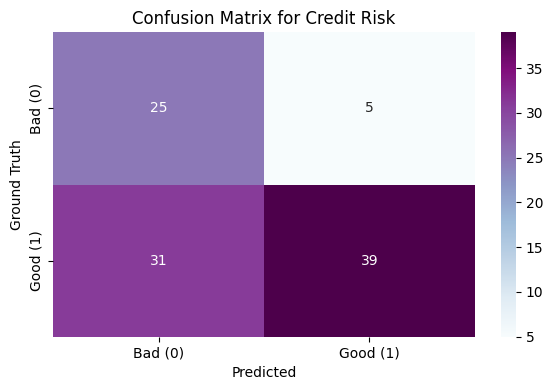

In [452]:
# decision tree
print(best_hyperparameters)
decision_tree_model = DecisionTreeClassifier(max_depth = best_hyperparameters['max_depth'],
                                             max_leaf_nodes=best_hyperparameters['max_leaf_nodes'],
                                             min_samples_split=best_hyperparameters['min_samples_split'],
                                             min_samples_leaf=best_hyperparameters['min_samples_leaf'],
                                             class_weight="balanced",
                                             criterion = 'entropy', random_state=0)


decision_tree_model.fit(np.array(X_train_processed), np.array(y_train)
)

y_pred_proba = decision_tree_model.predict_proba(X_eval_processed)[:, 1]
y_pred = decision_tree_model.predict(X_eval_processed)

evaluate_model(y_eval, y_pred, y_pred_proba)

Compared to the logistic regression classifier, the decision tree achieves a lower cost of 56 and is predicting more data points as bad. Except the per class precision for good credit risk (0.89), all other metrics are lower and the model makes 36 errors on 100 data points in the test set. However, since FPs are more costly, the model achieves a lower classification cost.

### Random Forest Classifier

In [453]:
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        class_weight="balanced",
        max_leaf_nodes=max_leaf_nodes,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=0
    )
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_val_processed)

    cm = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = cm.ravel()

    cost = fp * 5 + fn * 1 # apply cost matrix
    return cost

study = optuna.create_study(direction='minimize') # we want to minimize cost
study.optimize(objective, n_trials=100)

# best trial
trial = study.best_trial
best_hyperparameters = trial.params
print('Min cost: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Min cost: 44.0
Best hyperparameters: {'n_estimators': 121, 'max_depth': 10, 'max_leaf_nodes': 6, 'min_samples_split': 9, 'min_samples_leaf': 2}


              precision    recall  f1-score   support

           0       0.49      0.70      0.58        30
           1       0.84      0.69      0.76        70

    accuracy                           0.69       100
   macro avg       0.67      0.69      0.67       100
weighted avg       0.74      0.69      0.70       100

AUC Score: 0.8280952380952381
Total misclassification cost on test set: 67


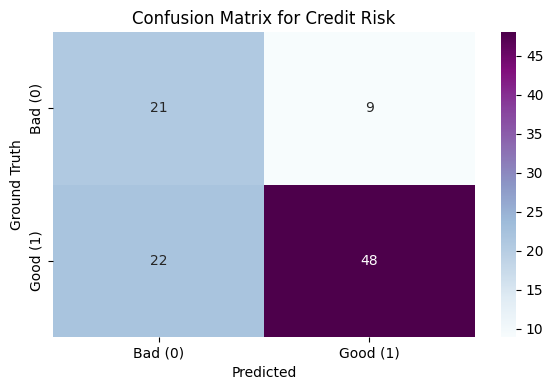

In [454]:
random_forest_model = RandomForestClassifier(n_estimators=best_hyperparameters['n_estimators'],
                                             max_depth = best_hyperparameters['max_depth'],
                                             max_leaf_nodes=best_hyperparameters['max_leaf_nodes'],
                                             min_samples_split=best_hyperparameters['min_samples_split'],
                                             min_samples_leaf=best_hyperparameters['min_samples_leaf'],
                                             class_weight="balanced",
                                             random_state=0)

random_forest_model.fit(X_train_processed, y_train)

y_pred = random_forest_model.predict(X_eval_processed)
y_pred_proba = random_forest_model.predict_proba(X_eval_processed)[:, 1]
evaluate_model(y_eval, y_pred, y_pred_proba)

Random forests are an ensemble of decision trees trained with bagging. They usually yield superior performance compared to one single decision tree since they compare the best splitting feature of a subset of trees (cf. Géron 2022: 197). The AUC score, as well as the f1-score are higher than for the decision tree, and the model makes less errors on the negative class. However, it makes 4 more FPs, resulting in an overall higher cost compared to the decision tree.

### Feature importances

When comparing the importances of the different features across models, it becomes clear that the decision tree model only takes into account one single feature: Status of existing checking account_A14. This one hot encoded feature of attribute 1 describes whether a person has a checking account or not. Looking at the distribution of this feature per label (see below) it becomes clear, that the majority of people without a checking account are generally considered good credit risk. Visualizing the tree and the decision boundary (bottom of the notebook) it becomes clear, that the model just makes one split, resulting in the lowest cost. However, it is questionable whether is constitutes a good model and this needs more analysis and exploration.

For the logistic regression model, the status of the existing checking account is the second most important feature (coefficient of 0.85). Furthermore, the purpose of taking a credit seems to be important as indicated by high coefficients. For example, buying a new car (A40) seems to be negatively correlated with a good credit risk. Moreover, the credit history features generally have high coefficients. Less important (as indicated by lower absolute coefficients are "Present residence since" and "No Dependents".

The random forest model shows differnt feature importances. While it equally shows high importance for the status of the checking account and the credit history, it also "Duration" and "Credit amount", features not listed in the top ten most important features of the logistic regression model. This underlines the differences in the models' algorithms in terms of capturing linear and non-linear interactions.

In [455]:
coefficients = model.coef_[0] # check coefficients of the logistic regression model to see which features are most important
#print(coefficients)

coef_df = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)}) # we want to account for both positive and negative coefficients as we are interested in the magnitude

coef_df_sorted = coef_df.sort_values(by='abs_coefficient', ascending=False, ignore_index=True) # sort coefficients descendingly

print("Logistic regression")
print("\nMost important features:")
print(coef_df_sorted[['feature','coefficient']].head(10)) # 30
print("\nLeast important features:")
print(coef_df_sorted[['feature','coefficient']].tail(10))

Logistic regression

Most important features:
                                   feature  coefficient
0                             Purpose_A410     1.149935
1  Status of existing checking account_A14     0.849075
2                              Purpose_A40    -0.813256
3                       Credit history_A34     0.795868
4  Status of existing checking account_A11    -0.735298
5          Other debtors / guarantors_A103     0.686840
6                       Credit history_A30    -0.654717
7                       Credit history_A31    -0.578474
8                              Purpose_A41     0.569636
9                      foreign worker_A202     0.552263

Least important features:
                         feature  coefficient
51  Present employment since_A73    -0.093890
52  Other installment plans_A141    -0.090014
53                   Purpose_A44     0.087443
54                 No Dependents    -0.075531
55   Personal status and sex_A92    -0.070261
56                   Purpose_A43   

                                    feature  importance
0   Status of existing checking account_A14         1.0
1                             Credit amount         0.0
2                          Installment rate         0.0
3                   Present residence since         0.0
4                                  Duration         0.0
..                                      ...         ...
56                                 Job_A174         0.0
57                           Telephone_A191         0.0
58                           Telephone_A192         0.0
59                      foreign worker_A201         0.0
60                      foreign worker_A202         0.0

[61 rows x 2 columns]


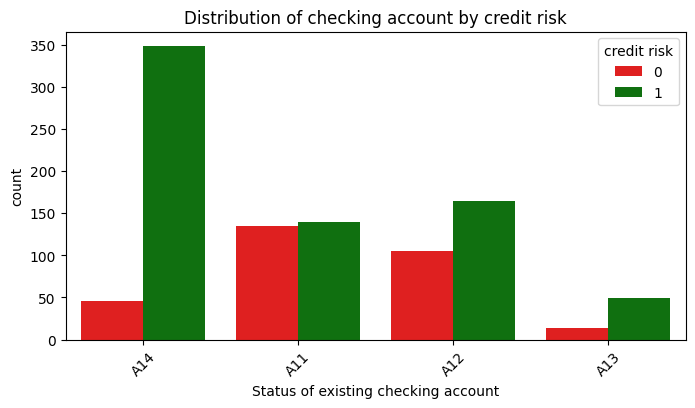

In [456]:
feature_importances = decision_tree_model.feature_importances_

feature_importances_dt_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': feature_importances
})

feature_importances_dt_df_sorted = feature_importances_dt_df.sort_values(by='importance', ascending=False, ignore_index=True)
print(feature_importances_dt_df_sorted)

palette = {1: 'green', 0: 'red'}


plt.figure(figsize=(8, 4))
sns.countplot(x=df['Status of existing checking account'], hue='credit risk', data=df, order=df['Status of existing checking account'].value_counts().index, palette=palette)
plt.title(f"Distribution of checking account by credit risk")
plt.xticks(rotation=45)
plt.show()

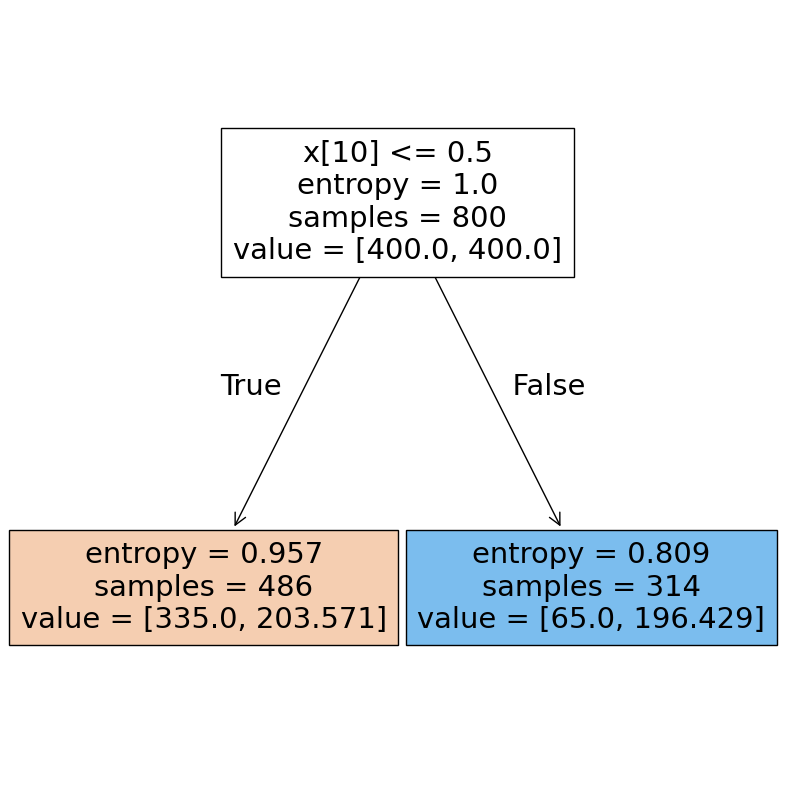

In [457]:
from sklearn import tree
plt.figure(figsize=(10,10))
tree.plot_tree(decision_tree_model, filled=True)
plt.show()

In [458]:
feature_importances = random_forest_model.feature_importances_

feature_importances_dt_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': feature_importances
})

feature_importances_dt_df_sorted = feature_importances_dt_df.sort_values(by='importance', ascending=False, ignore_index=True)

print(feature_importances_dt_df_sorted.head(10))
print(feature_importances_dt_df_sorted.tail(10))

                                   feature  importance
0  Status of existing checking account_A14    0.224866
1  Status of existing checking account_A11    0.117946
2                                 Duration    0.083904
3                            Credit amount    0.065960
4                       Credit history_A34    0.065708
5  Status of existing checking account_A12    0.035560
6                                      Age    0.033825
7                Savings account/bonds_A65    0.031556
8                            Property_A124    0.025565
9                Savings account/bonds_A61    0.025376
                        feature  importance
51                No Dependents    0.000572
52  Personal status and sex_A93    0.000542
53  Personal status and sex_A94    0.000443
54                  Purpose_A46    0.000198
55                 Purpose_A410    0.000000
56                  Purpose_A44    0.000000
57                  Purpose_A45    0.000000
58  Personal status and sex_A91    0.000000

**Extra**: Any additional discussion and extra work relevant for solving the problem is welcome by the student and will contribute to a better grade.

#### Finding the optimal decision threshold for logistic regression

Since we want to decrease FPs, I experimented with finding a threshold that minimizes the overall cost. The hypothesis is that a more conservative classifier that only predicts the positive class when the probability is very high, should lead to a lower overall cost. The lowest cost on the validation set is achieved for a threshold of 0.96 (57), which is slightly less than for the logistic regression model with a default threshold of 0.5 (see above, 82). However, the model now is very biased towards prediciting the negative class. It might be worth considering applying different strategies to balance the class imbalance in the dataset or to use k-fold cross validation.

Optimal found threshold: 0.96
Minimum cost: 65
              precision    recall  f1-score   support

           0       0.34      1.00      0.51        30
           1       1.00      0.19      0.31        70

    accuracy                           0.43       100
   macro avg       0.67      0.59      0.41       100
weighted avg       0.80      0.43      0.37       100

AUC Score: 0.8285714285714285
Total misclassification cost on test set: 57


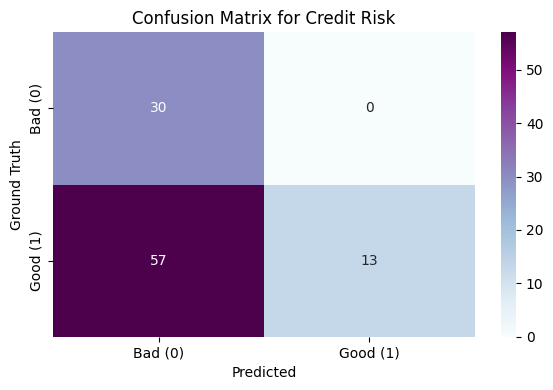

In [459]:
# reduce FPs by changing classification threshold
y_probs = model.predict_proba(X_val_processed)[:, 1] # get the probabilities

thresholds = np.linspace(0, 1, 100) # thresholds we want to test (between 0 and 1)
#print(thresholds)
costs = []

for t in thresholds:
    y_pred = (y_probs >= t).astype(int) # get the predicted
    tn, fp, fn, tp = confusion_matrix(y_eval, y_pred).ravel()
    cost = (fp * 5) + (fn * 1)
    costs.append(cost)

optimal_idx = np.argmin(costs)
optimal_threshold = thresholds[optimal_idx]
min_cost = costs[optimal_idx]

print(f"Optimal found threshold: {optimal_threshold:.2f}")
print(f"Minimum cost: {min_cost}")

# test on the test set and apply the new threshold
y_probs_eval = model.predict_proba(X_eval_processed)[:, 1]
y_pred = (y_probs_eval >= optimal_threshold).astype(int)

evaluate_model(y_eval, y_pred, y_probs_eval)

#### Feature Engineering

To test whether we can improve the logistic regression classification, I eliminated two numeric columns that had very low coefficients for logistic regression: "No Dependents" and "Present residence since".

              precision    recall  f1-score   support

           0       0.34      1.00      0.51        30
           1       1.00      0.19      0.31        70

    accuracy                           0.43       100
   macro avg       0.67      0.59      0.41       100
weighted avg       0.80      0.43      0.37       100

AUC Score: 0.8304761904761905
Total misclassification cost on test set: 57


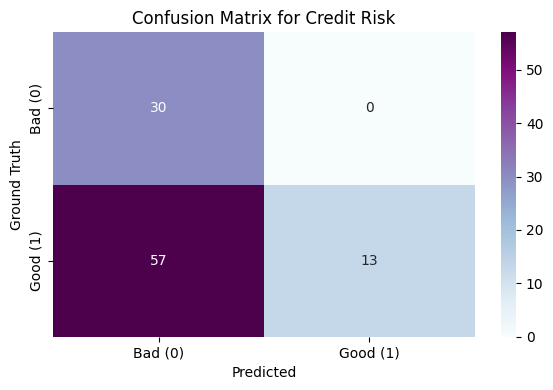

In [463]:
X = X.drop(['No Dependents', 'Present residence since'], axis=1)

categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns # we want to scale only the numerical values

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols) # apply one hot encoding to categorical columns
    ])

X_transformed = preprocessor.fit_transform(X)
X_transformed.shape

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y) # use stratified sampling
X_eval, X_val, y_eval, y_val = train_test_split(X_eval, y_eval, test_size=0.5, random_state=0, stratify=y_eval)

X_train_processed = preprocessor.transform(X_train)
X_eval_processed = preprocessor.transform(X_eval)
X_val_processed = preprocessor.transform(X_val)

model = LogisticRegression(solver="lbfgs", max_iter=1000)
model.fit(X_train_processed, y_train)

y_pred_proba = model.predict_proba(X_eval_processed)[:, 1]
evaluate_model(y_eval, y_pred, y_pred_proba)

### Having a look at decision boundaries (not part of extra work, just to visualize the decision boundary for the decision tree analysis above).

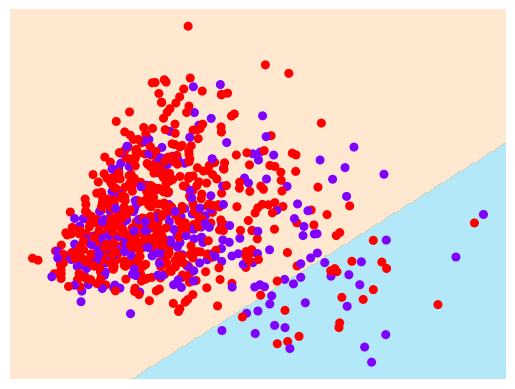

In [460]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_processed)
y_train_1d = y_train.values.ravel()


def visualize_classifier(model, X, y, ax=None, cmap='rainbow'): # code taken from Random_Forests_walkthrough.ipynb
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

visualize_classifier(model, X_train_2d, y_train_1d)


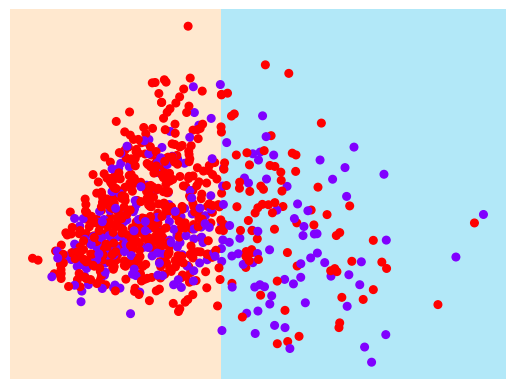

In [461]:
visualize_classifier(decision_tree_model, X_train_2d, y_train_1d)

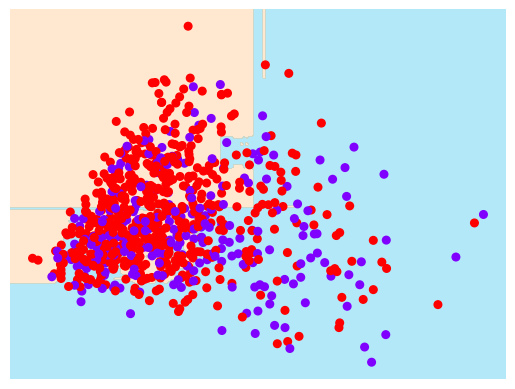

In [462]:
visualize_classifier(random_forest_model, X_train_2d, y_train_1d)

#### References

Géron, A. (2022). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow. " O'Reilly Media, Inc.".